# process spectra for AuxTel with new spectractor (September 2021): Part 1 guess (x,y) of order 0

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : June 16th 2021
- up date : September 21th  2021
- update : September 24th 2021 : quickLookExp and run locally
- update : September 29th 2021 : for diffusion
- version v3


This notebook is to help for finding the position of order 0

CCIN2P3:

- works with kernels **anaconda3_auxtel** (with libradtran) and **anaconda3_auxtel_v2** (no libradtran)
- works with kernel **python 3** locally 

# Scan

    # wide scan : HD 160617 
    # all_myseq_holo=range(234,310)
    # narrow scan :  HD 160617 
    # all_myseq_holo=range(317,365)


# Imports

In [35]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [36]:
from iminuit import Minuit
import iminuit

In [37]:
iminuit.__version__

'2.7.0'

In [38]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.images import *
from scipy import ndimage, misc

In [39]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [40]:
from distutils.dir_util import copy_tree

# Configuration

In [41]:
# create output directories if not exist and clean existing files
FLAG_MANAGE_OUTPUT_SPECTRACTOR=True
# allow to run reconstruction with Spectractor
FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR=True

# Path

In [42]:
# path index for each month
DATE="2021-07-07"
DATE2="2021_07_07"

In [43]:
# select if we run at CC or not (locally) 
HOSTCC=True

In [44]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2021/holo/quickLookExp/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"data/2021/holo/OutputSpectractor/"+DATE)
    
else:
    path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_spectractor=os.path.join(path_auxtel,"/users/dagoret/MacOSX/github/LSST/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"holo/quickLookExp/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"holo/OutputSpectractor/"+DATE)

# Utility Functions

In [45]:
def file_tag_forsorting(filename):
    #m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m=re.findall('^holo4_003_*_(.*)_.*_quickLookExp[.]fits$',filename)
    #print(m)
    words=m[0].split("_")
    
    outputstring=words[1]
    
    if outputstring=="slew":
        outputstring+="_icrs"
    return outputstring

In [46]:
def file_target(filename):
    m=file_tag_forsorting(filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []
         

In [47]:
def is_nan(x):
    return (x != x)

# Logbook for input file selection

- the logbook contains all input image path and possibily the order 0 position

In [48]:
filename_logbook='logbooks/auxtelholologbook_'+DATE2+'_v3.0.csv'

In [49]:
df=pd.read_csv(filename_logbook,index_col=0)

In [50]:
pd.set_option('display.max_rows', None)

In [51]:
# show the list of input files from the logbook to select the file index in the logbook
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-07-08T02:50:31.569,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000234_quick...,234,HD160617,RG610,holo4_003,1.022300,5.0,...,12.1,6.0,3.8,600.0,2100.0,NaN,NaN,,1.0,1.0
1,1,2021-07-08T02:51:12.101,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000235_quick...,235,HD160617,RG610,holo4_003,1.022020,5.0,...,12.1,6.0,4.4,600.0,2100.0,NaN,NaN,,1.0,1.0
2,2,2021-07-08T02:51:21.256,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000236_quick...,236,HD160617,RG610,holo4_003,1.021958,5.0,...,12.1,6.0,4.4,600.0,2100.0,NaN,NaN,,1.0,1.0
3,3,2021-07-08T02:51:30.934,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000237_quick...,237,HD160617,RG610,holo4_003,1.021893,5.0,...,12.1,6.0,4.4,600.0,2100.0,NaN,NaN,,1.0,1.0
4,4,2021-07-08T02:51:40.885,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000238_quick...,238,HD160617,RG610,holo4_003,1.021826,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0
5,5,2021-07-08T02:51:50.381,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000239_quick...,239,HD160617,RG610,holo4_003,1.021763,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0
6,6,2021-07-08T02:51:59.759,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000240_quick...,240,HD160617,RG610,holo4_003,1.021700,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0
7,7,2021-07-08T02:52:10.113,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000241_quick...,241,HD160617,RG610,holo4_003,1.021631,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0
8,8,2021-07-08T02:52:19.262,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000242_quick...,242,HD160617,RG610,holo4_003,1.021572,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0
9,9,2021-07-08T02:52:29.022,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000243_quick...,243,HD160617,RG610,holo4_003,1.021508,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0


# Selection of input file
- the input file is selected from the logbook list above

In [52]:
# wide scan : HD 160617 
# all_myseq_holo=range(234,310)

# narrow scan :  HD 160617 
# all_myseq_holo=range(317,365)

In [53]:
idx=96

In [54]:
print(df.iloc[idx]['file'])

holo4_003_empty_HD160617_20210707_000337_quickLookExp.fits


In [55]:
print(df.iloc[idx])

index                                                         96
date                                     2021-07-08T05:00:18.159
path           /Users/dagoret/DATA/AuxTelData2021/holo/quickL...
file           holo4_003_empty_HD160617_20210707_000337_quick...
num                                                          337
object                                                  HD160617
filter                                                   empty_1
disperser                                              holo4_003
airmass                                                 1.079806
exposure                                                    20.0
focus                                                  -1.577194
seeing                                                       NaN
pressure                                                  742.25
temperature                                                 12.6
humidity                                                     6.0
windspd                  

In [56]:
myhome=os.getenv("HOME")

In [57]:
dir_images=path_images

In [58]:
filename_image=df['file'][idx]
filename_image

'holo4_003_empty_HD160617_20210707_000337_quickLookExp.fits'

In [59]:
file_target(filename_image)

'HD160617'

## If order 0 position exists in logbook it is selected, otherwise put it by hand

In [60]:
x0=df['Obj-posXpix'][idx]
y0=df['Obj-posYpix'][idx]

In [61]:
FLAG_ORDER0_LOCATION=False

In [62]:
if not is_nan(x0)and not is_nan(y0):
    FLAG_ORDER0_LOCATION=True
    print("Order 0 location from logbook : ({},{})".format(x0,y0))
else:
    print("NO Order 0 location from logbook ! ")      

Order 0 location from logbook : (300.0,1600.0)


## Spectractor Configuration 

- Usually the Spectractor configuration file is put in local dir **./config**


Ma suggestion, pour l'étude du centre optique via les scans des hologrammes, est de **mettre SPECTRACTOR_COMPUTE_ROTATION_ANGLE sur False** . 

Comme les angles ne sont pas très grands, si les marges du rectangle sont assez larges, réglables avec : 

    [background subtraction parameters] 
    # half transverse width of the signal rectangular window in pixels 
    PIXWIDTH_SIGNAL = 40 

alors le spectrogramme devrait tenir dans une boite rectangulaire même sans rotation de l'image. **L'important est de garder SPECTRACTOR_DECONVOLUTION_FFM à True car c'est lui qui te donnera l'angle de l'axe de dispersion ajusté sur les données, dont la valeur sera dans le mot clé ROTANGLE du header de sortie**. 


In [63]:
filename_image.split(".")[0]

'holo4_003_empty_HD160617_20210707_000337_quickLookExp'

In [64]:
path_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07'

In [65]:

# Fullfilename
filename=os.path.join(dir_images,filename_image)


# subdirectory
subdir=filename_image.split(".")[0]

# final output directory (where results will be copied to be backed up at the end)
finalpath_output_spectractor=os.path.join(path_output_spectractor,subdir)

# local directories to put spectra and plots
output_directory="./outputs_process_holo_scan"
output_figures="figures_process_holo_scan"

# Final output directory


guess = [250,2600]
disperser_label = "holo4_003"
# old version
# config = os.path.join(path_spectractor_config,"auxtel_quicklook.ini")
# new version (September 20th 2021)

# configuration

# standard spectractor init configuration
#config = os.path.join(path_spectractor_config,"auxtel.ini")
# special for scan in XY
config="./config/auxtel_scanXY.ini"

target = file_target(filename_image)[0]

In [66]:
finalpath_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000337_quickLookExp'

### manage output dir

In [67]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                os.remove(os.path.join(path,f))

In [68]:
# this flag must be set if one want to clean results from previous runs
if FLAG_MANAGE_OUTPUT_SPECTRACTOR:
    
    # manage global output directory of spectractor
    # Basically it has the name of the input file image
    if not os.path.isdir(output_directory):
        os.mkdir(output_directory)
    else:
        cleandir(output_directory)
 
    # manage subdirs spectrum/ and plots/
    if not os.path.isdir(output_figures):
        os.mkdir(output_figures)
    else:
        cleandir(output_figures)
    
    if not os.path.isdir(finalpath_output_spectractor):
        os.mkdir(finalpath_output_spectractor)
        os.mkdir(os.path.join(finalpath_output_spectractor,"basespec"))
        os.mkdir(os.path.join(finalpath_output_spectractor,"plots"))
    else:
        #cleandir(finalpath_output_spectractor)
        cleandir(os.path.join(finalpath_output_spectractor,"basespec"))
        cleandir(os.path.join(finalpath_output_spectractor,"plots"))

# Configuration of the Spectractor running mode

In [69]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [70]:
#parameters.DISPERSER_DIR = os.path.join(spectractor_dir, "extractor/dispersers/")
#parameters.CONFIG_DIR = os.path.join(spectractor_dir, "../config/")
#parameters.THROUGHPUT_DIR = os.path.join(spectractor_dir, "simulation/CTIOThroughput/")

# Transform the input file

- the image fits format extracted from quickLookExp images at NCSA has not the exact format required by Spectractor.

In [71]:
from shutil import copyfile

In [72]:
copyfile(filename,filename_image)

'holo4_003_empty_HD160617_20210707_000337_quickLookExp.fits'

In [73]:
from astropy.io import fits

In [74]:
hdu = fits.open(filename_image)

In [75]:
hdu.info()

Filename: holo4_003_empty_HD160617_20210707_000337_quickLookExp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     124   (4072, 4000)   float32   


In [76]:
# extract header and the image
header=hdu[0].header
image=hdu[0].data

In [77]:
hdu.close()

## Rotate image

- rotate the image according what is expected in Spectractor

In [78]:
rot_image=np.flip(np.flip(image, 1), 0)

### Remove WCS

- may not be necessary

In [79]:
del header['WCSAXES']
del header['CTYPE1']
del header['CTYPE2']
del header['CUNIT1']
del header['CUNIT2']
del header['CRVAL1']
del header['CRVAL2']
del header['CRPIX1']
del header['CRPIX2']

## Reshape the file for load_image_AUXTEL() in Spectractor/spectractor/extractor/images.py

In [80]:
primary_hdu = fits.PrimaryHDU(header=header)
image_hdu = fits.ImageHDU(rot_image)

In [81]:
hdu_list = fits.HDUList([primary_hdu, image_hdu])

In [82]:
hdu_list.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     114   ()      
  1                1 ImageHDU         7   (4072, 4000)   float32   


In [83]:
hdu_list.writeto(filename_image,overwrite=True)

## Load the image in the new image file with Spectractor

In [84]:
#image=Image(file_name=filename, target_label=target, disperser_label=disperser_label, config=config)
image=Image(file_name=filename_image, target_label=target, disperser_label=disperser_label, config=config)

## Show relevant parameters

In [85]:
parameters.OBS_NAME

'AUXTEL'

In [86]:
parameters.DISPERSER_DIR

'/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/'

In [87]:
parameters.DISTANCE2CCD

182.0

In [88]:
parameters.LAMBDA_MIN 

300

In [89]:
parameters.LAMBDA_MAX 

1100

In [90]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [91]:
image.filter_label

''

In [92]:
image.header["FILTER"]

'empty_1'

In [93]:
#image.header

# Plot image and find the target position

- this image plotting is used to find the order 0 location to be set in logbook

- for the moment this is humanly done

## Load the new image file with Spectractor

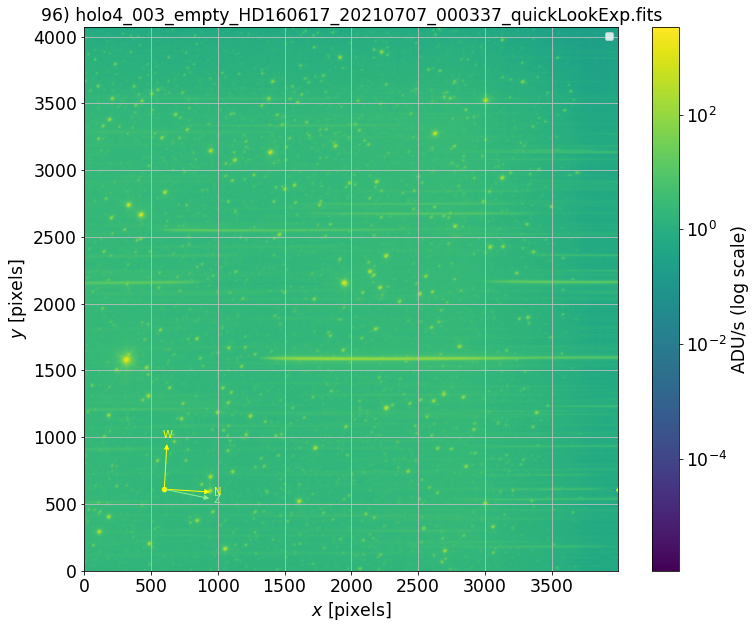

In [94]:
title="{}) {}".format(idx,filename_image)
image.plot_image(figsize=(12, 10),scale="log",title=title)

In [95]:
# with filter
guess = [600., 2100.] # filename_image=df['file'][0] , holo4_003_RG610_HD160617_20210707_000234_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][1] , holo4_003_RG610_HD160617_20210707_000235_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][2] , holo4_003_RG610_HD160617_20210707_000236_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][3] , holo4_003_RG610_HD160617_20210707_000237_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][4] , holo4_003_RG610_HD160617_20210707_000238_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][5] , holo4_003_RG610_HD160617_20210707_000239_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][6] , holo4_003_RG610_HD160617_20210707_000240_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][7] , holo4_003_RG610_HD160617_20210707_000241_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][8] , holo4_003_RG610_HD160617_20210707_000242_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][9] , holo4_003_RG610_HD160617_20210707_000243_quickLookExp.fits
guess = [1300., 700.] # filename_image=df['file'][10] , holo4_003_RG610_HD160617_20210707_000244_quickLookExp.fits
guess = [250., 1800.] # filename_image=df['file'][11] , holo4_003_RG610_HD160617_20210707_000245_quickLookExp.fits
guess = [250., 1800.] # filename_image=df['file'][12] , holo4_003_RG610_HD160617_20210707_000246_quickLookExp.fits
guess = [250., 1800.] # filename_image=df['file'][13] , holo4_003_RG610_HD160617_20210707_000247_quickLookExp.fits


# wide scan
guess = [1400., 700.] # filename_image=df['file'][14] , holo4_003_empty_HD160617_20210707_000248_quickLookExp.fits
guess = [1400., 800.] # filename_image=df['file'][15] , holo4_003_empty_HD160617_20210707_000249_quickLookExp.fits
guess = [400., 1800.] # filename_image=df['file'][16] , holo4_003_empty_HD160617_20210707_000250_quickLookExp.fits
guess = [400., 1800.] # filename_image=df['file'][17] , holo4_003_empty_HD160617_20210707_000251_quickLookExp.fits
guess = [400., 1800.] # filename_image=df['file'][18] , holo4_003_empty_HD160617_20210707_000252_quickLookExp.fits
#guess = [50., 800.] # filename_image=df['file'][19] , holo4_003_empty_HD160617_20210707_000253_quickLookExp.fits
#guess = [50., 800.] # filename_image=df['file'][20] , holo4_003_empty_HD160617_20210707_000254_quickLookExp.fits
#guess = [50., 800.] # filename_image=df['file'][21] , holo4_003_empty_HD160617_20210707_000255_quickLookExp.fits

#

# narrrow scan

guess = [500.,2100.] # filename_image=df['file'][76] , 'holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits'
guess = [500.,2100.] # filename_image=df['file'][77] , 'holo4_003_empty_HD160617_20210707_000318_quickLookExp.fits'
guess = [500.,1800.] # filename_image=df['file'][78] , 'holo4_003_empty_HD160617_20210707_000319_quickLookExp.fits'
guess = [500.,1800.] # filename_image=df['file'][79] , 'holo4_003_empty_HD160617_20210707_000320_quickLookExp.fits'
guess = [500.,1300.] # filename_image=df['file'][80] , 'holo4_003_empty_HD160617_20210707_000321_quickLookExp.fits'

- note now the position are written in the make_logbook.ipynb notebook

## Set the 0th order location to be provided to Spectractor

In [96]:
filename_image

'holo4_003_empty_HD160617_20210707_000337_quickLookExp.fits'

In [97]:
# overwrite if localtion is taken from that in logbook
if FLAG_ORDER0_LOCATION : 
    print("Set Order 0 location from logbook : ({},{})".format(x0,y0))
    guess = [x0,y0]

Set Order 0 location from logbook : (300.0,1600.0)


## Let Spectractor find the location of the 0th order

2021-09-29 13:54:16  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                  c0_1        
    ------------------ -------------------- ---------------------
    4.8881389468276595 0.009091680918908492 -0.009568984249561405
2021-09-29 13:54:17  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 21 iterations because the relative change of cost is below ftol=1.25e-05.


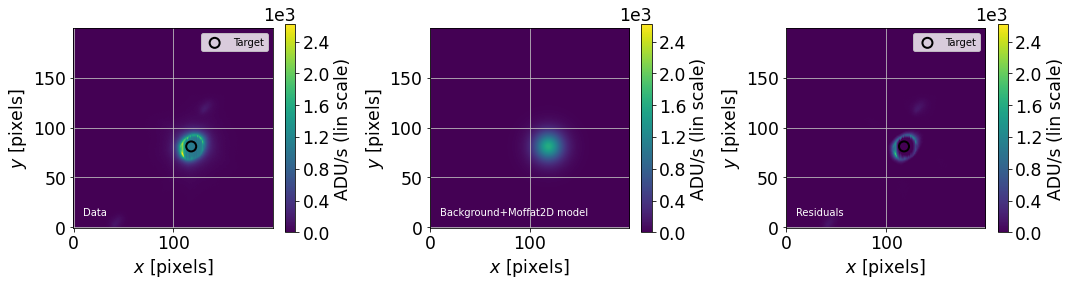

2021-09-29 13:54:18  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 4 iterations because the relative change of cost is below ftol=5e-05.


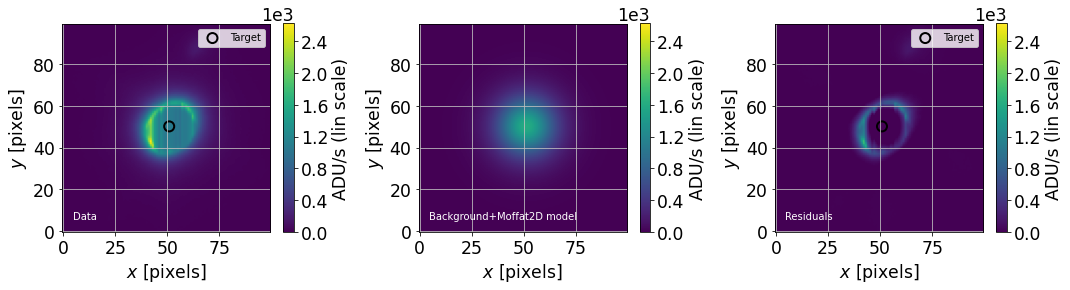

In [98]:

parameters.VERBOSE = True
parameters.DEBUG = True
#x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
x1, y1 = find_target(image, guess,rotated=False)

In [99]:
print(x1,y1)

317.90669121905773 1581.1451474892867


## Check the location of 0th order and Analysis of the quality of its focus

In [100]:
if x1>100:
    WID=100
else:
    WID=50
    

thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
thumbnail_y=thumbnail.sum(axis=1)
thumbnail_x=thumbnail.sum(axis=0)
xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
kx=kurtosis(thumbnail_x,bias=True,fisher=True)
ky=kurtosis(thumbnail_y,bias=True,fisher=True)
s0=skew(thumbnail,axis=None,bias=True)
sx=skew(thumbnail_x,bias=True)
sy=skew(thumbnail_y,bias=True)
        

In [101]:
shape_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
        r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))

In [102]:
skew_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}'.format(s0),
        r'             : Skx = {:3.3f}'.format(sx),
        r'             : Sky = {:3.3f}'.format(sy)))

In [103]:
kurt_str='\n'.join((
        r'kurtosis : K0 = {:3.3f}'.format(k0),
        r'             : Kx = {:3.3f}'.format(kx),
        r'             : Ky = {:3.3f}'.format(ky)))

In [104]:
kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
skew_test_prob=skewtest(thumbnail,axis=None).pvalue
normal_test_prob=normaltest(thumbnail,axis=None).pvalue

In [105]:
kurtosis_test_val=kurtosistest(thumbnail,axis=None).statistic
skew_test_val=skewtest(thumbnail,axis=None).statistic
normal_test_val=normaltest(thumbnail,axis=None).statistic

In [106]:
kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
skew_test_prob_x=skewtest(thumbnail_x).pvalue
normal_test_prob_x=normaltest(thumbnail_x).pvalue

In [107]:
kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
skew_test_prob_y=skewtest(thumbnail_y).pvalue
normal_test_prob_y=normaltest(thumbnail_y).pvalue

In [108]:
skew_str='\n'.join((
    r'skew     : Sk0 = {:3.3f}'.format(s0),
    r'             : Skx = {:3.3f}'.format(sx),
    r'             : Sky = {:3.3f}'.format(sy),
    r'             : p_test   = {:3.3e}'.format(skew_test_prob),
    r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))

In [109]:
kurt_str='\n'.join((
    r'kurtosis : K0 = {:3.3f}'.format(k0),
    r'             : Kx = {:3.3f}'.format(kx),
    r'             : Ky = {:3.3f}'.format(ky),
    r'             : p_test   = {:3.3e}'.format(kurtosis_test_prob),
    r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))

In [110]:
norm_str='\n'.join((
    r'normal  : p_test   = {:3.3e}'.format(normal_test_prob),
    r'             : p_test_x = {:3.3e}'.format(normal_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))

In [111]:
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [112]:
#matplotlib.pyplot.hist(x, 
#                       bins=10, 
#                       range=None, 
#                       normed=False, 
#                       weights=None, 
#                       cumulative=False, 
#                       bottom=None, 
#                       histtype=u'bar', 
#                       align=u'mid', 
#                       orientation=u'vertical', 
#                       rwidth=None, 
#                       log=False, 
#                       color=None, 
#                       label=None, 
#                       stacked=False, 
#                       hold=None, 
#                       **kwargs)

<ipython-input-113-9da0d4ef5b3f>:32: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.suptitle(title,Y=1.01)


Text(0.5, 1.01, '96) holo4_003_empty_HD160617_20210707_000337_quickLookExp.fits')

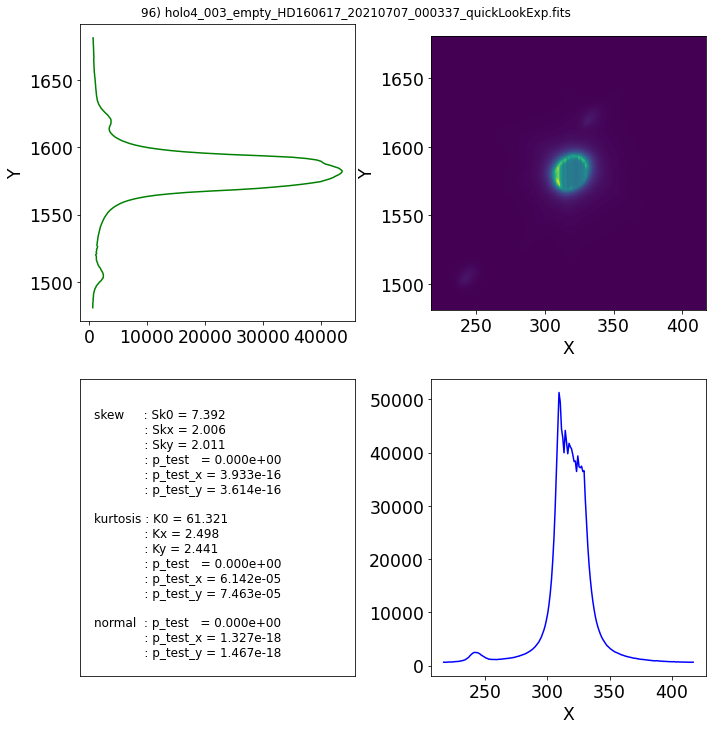

In [113]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

ax=fig.add_subplot(222)
ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax=fig.add_subplot(221)
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)
#ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
ax.set_ylabel("Y")

ax=fig.add_subplot(224)
ax.plot(xx,thumbnail_x,"b")
ax.set_xlabel("X")
plt.tight_layout()

ax=fig.add_subplot(223)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
plt.suptitle(title,Y=1.01)

In [114]:
# Usually stop here if one just want to get the 0th order location
if not FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR:
    assert False
else:
    assert True

# Go for spectrum reconstruction

In [115]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

2021-09-29 13:54:20  spectractor.extractor.extractor Spectractor          INFO   
	Start SPECTRACTOR
2021-09-29 13:54:20  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image holo4_003_empty_HD160617_20210707_000337_quickLookExp.fits...
2021-09-29 13:54:20  Image      load_AUXTEL_image    INFO   
	Image loaded


Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: pipeline
x spectractor_fit_target_centroid: fit	=> parameters.SPECTRACTOR_FIT_TARGET_CENTROID: fit	 <class 'str'>
x spectractor_compute_rotation_angle: False	=> parameters.SPECTRACTOR_COMPUTE_ROTATION_ANGLE: False	 <class 'bool'>
x spectractor_deconvolution_psf2d: False	=> parameters.SPECTRACTOR_DECONVOLUTION_PSF2D: False	 <class 'bool'>
x spectractor_deconvolution_ffm: True	=> parameters.SPECTRACTOR_DECONVOLUTION_FFM: True	 <class 'bool'>
Section: instrument
x obs_name: AUXTEL	=> parameters.OBS_NAME: AUXTEL	 <class 'str'>
x obs_altitude: 2.66299616375123	=> par

2021-09-29 13:54:20  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-09-29 13:54:20  Hologram   load_specs           INFO   
	Load disperser holo4_003:
	from /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/holo4_003
2021-09-29 13:54:20  Hologram   load_specs           INFO   
	Grating characteristics:
	N = 156.00 +/- 1.00 grooves/mm
	Average tilt of -0.3 degrees
2021-09-29 13:54:25  Star       load                 INFO   
	Simbad:
 MAIN_ID        RA           DEC      ... Z_VALUE_2 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
HD 160617 17 42 49.3235 -40 19 15.505 ... 0.0003350                1
2021-09-29 13:54:25  Star       load_spectra         INFO   
	Loading /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/hd160617_stis_001.fits
2021-09-29 13:54:25  Star       load_

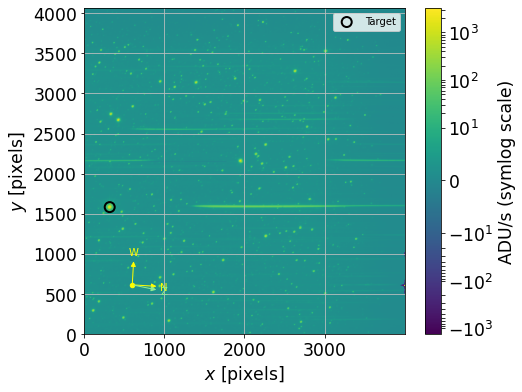

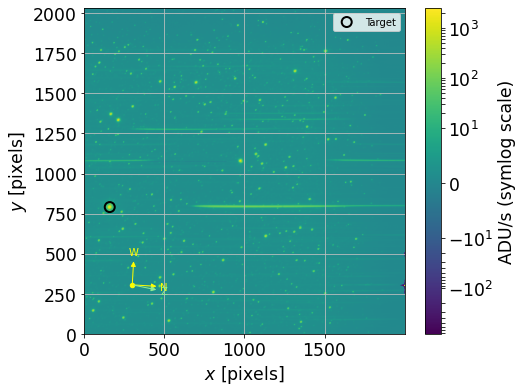

2021-09-29 13:54:32  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the image with guess=[158.95334561 790.57257374]...
2021-09-29 13:54:32  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                 c0_1        
    ----------------- --------------------- --------------------
    4.765087818985727 -0.002740170192606732 0.001552357696349057
2021-09-29 13:54:32  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 15 iterations because the relative change of cost is below ftol=5e-05.


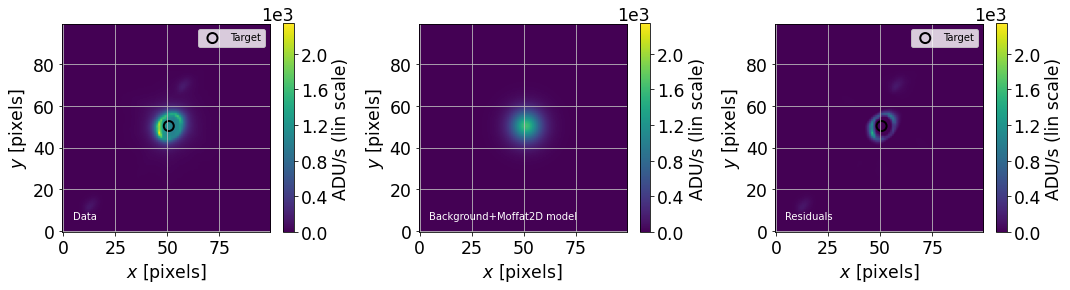

2021-09-29 13:54:33  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=0.0002.


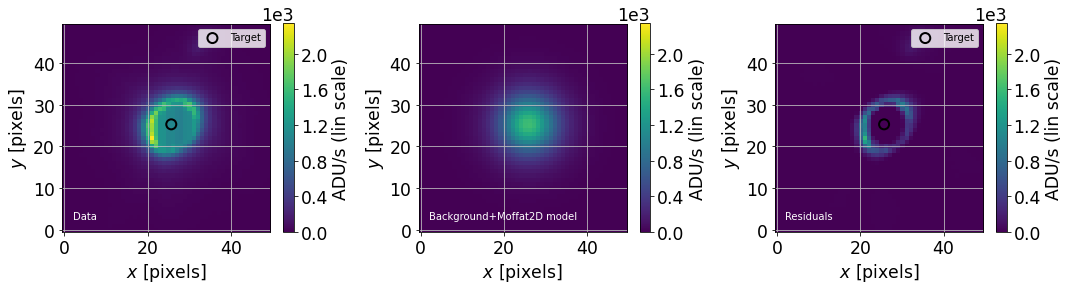

2021-09-29 13:54:34  Image      find_target          INFO   
	X,Y target position in pixels: 158.705,790.317
2021-09-29 13:54:34  Image      turn_image           INFO   
	Rotate the image with angle theta=0.00 degree


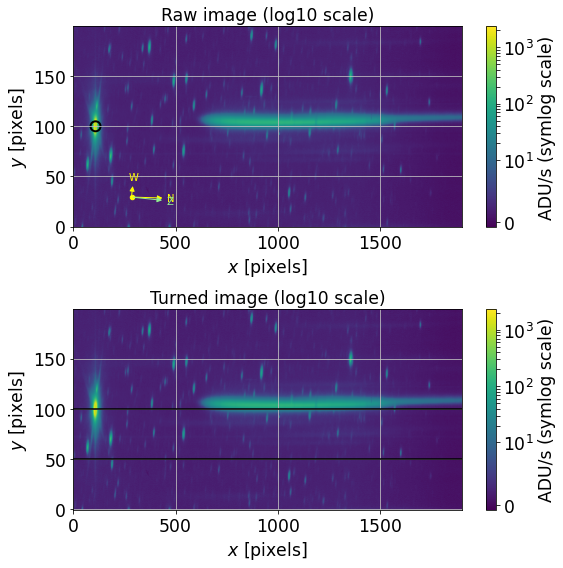

2021-09-29 13:54:38  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the rotated image...
2021-09-29 13:54:38  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                c0_1       
    ------------------ ------------------- -------------------
    14.051912780048172 0.12899131792126103 0.06746633894999415
2021-09-29 13:54:38  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 5 iterations because the sum of parameter shift relative to the sum of the parameters is below xtol=1e-06.


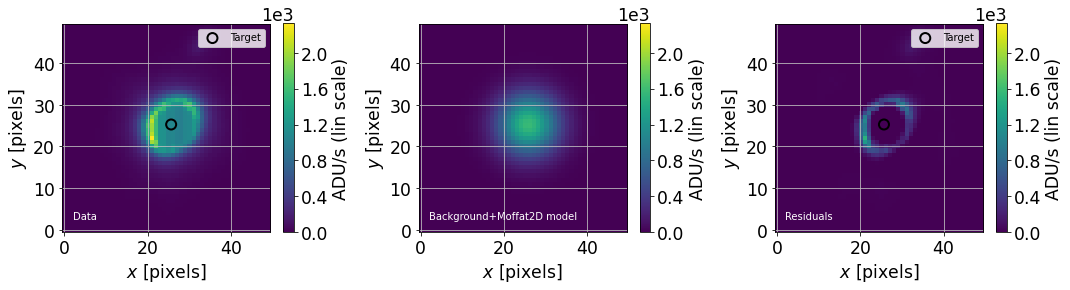

2021-09-29 13:54:39  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 5 iterations because the sum of parameter shift relative to the sum of the parameters is below xtol=1e-06.


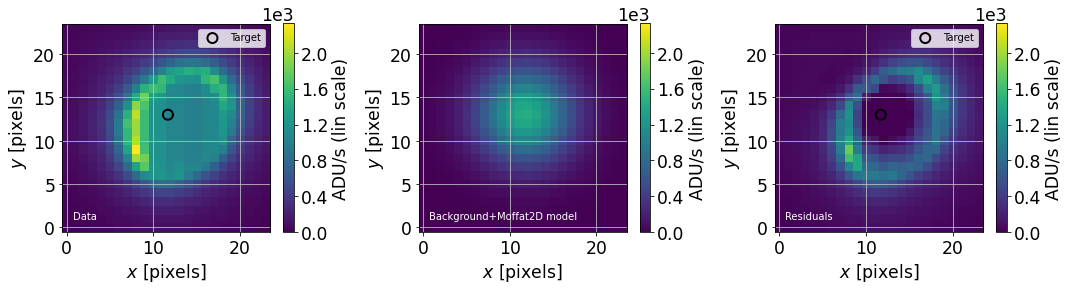

2021-09-29 13:54:40  Image      find_target          INFO   
	X,Y target position in pixels: 157.695,791.003
2021-09-29 13:54:40  Spectrum   __init__             INFO   
	Spectrum info copied from image
2021-09-29 13:54:40  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extracting spectrum from image: spectrum with width 2*20 pixels and background from 70 to 90 pixels
2021-09-29 13:54:40  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop rotated image [584:1742,701:881] (size (1158, 180))


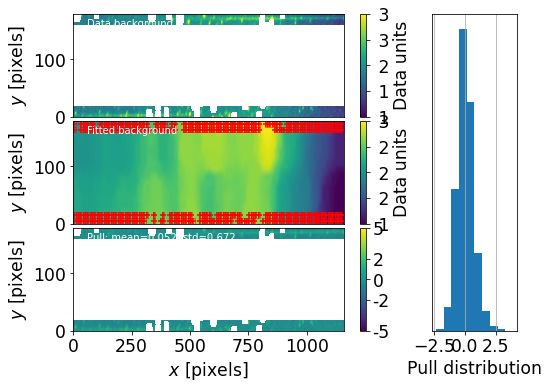

2021-09-29 13:54:43  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Start PSF1D transverse fit...


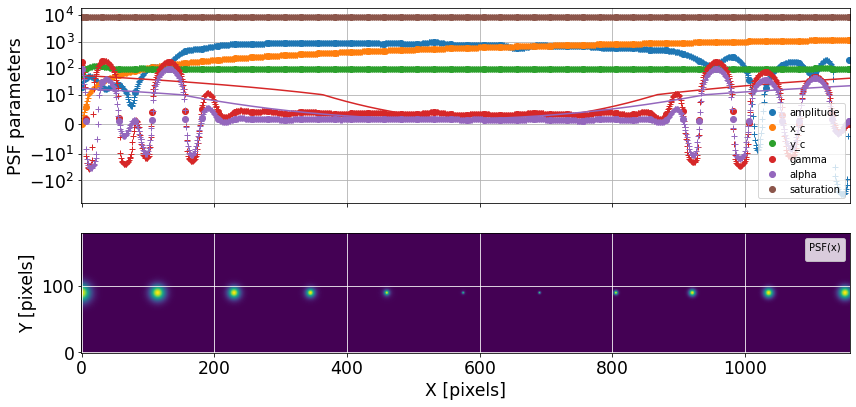

2021-09-29 13:54:47  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=2.7117e+05 initial chisq_red=5.8542
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ 0.19644401  0.19830826  0.56014871 -2.38387507 -1.60511647 -5.67290355
 -1.669383   -1.30485582 -3.90398546]
	New parameters: [ 4.18804739  0.99786991  2.38889642  4.37770299 -0.3772381   2.33664955
  1.67275575 -0.38510102  0.40754722]
	Final cost=2.2406e+05 final chisq_red=4.8373 computed in 0.67s
2021-09-29 13:54:47  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=2.2406e+05 initial chisq_red=4.8373
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-0.01568869 -0.00661529 -0.03882673 -0.20480878 -0.16907296 -0.81477783
  0.09540221  0.10008255 -0.04706775]
	New parameters: [ 4.1723587   0.99125462  2.35006969  4.17289421 -0.54631106  1.52187172
  1.76815796 -0.28501847  0.36047947]
	Final cost=1.8799e+05 final chisq_red=4.0584 computed i

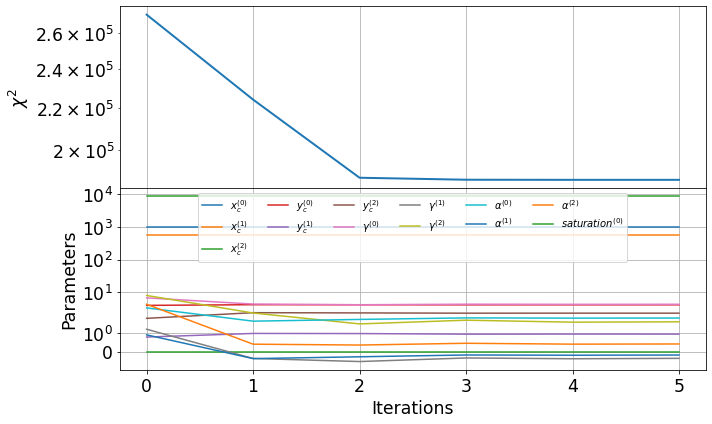

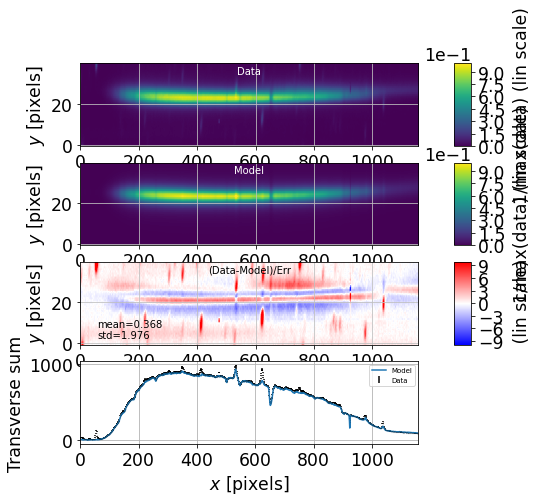

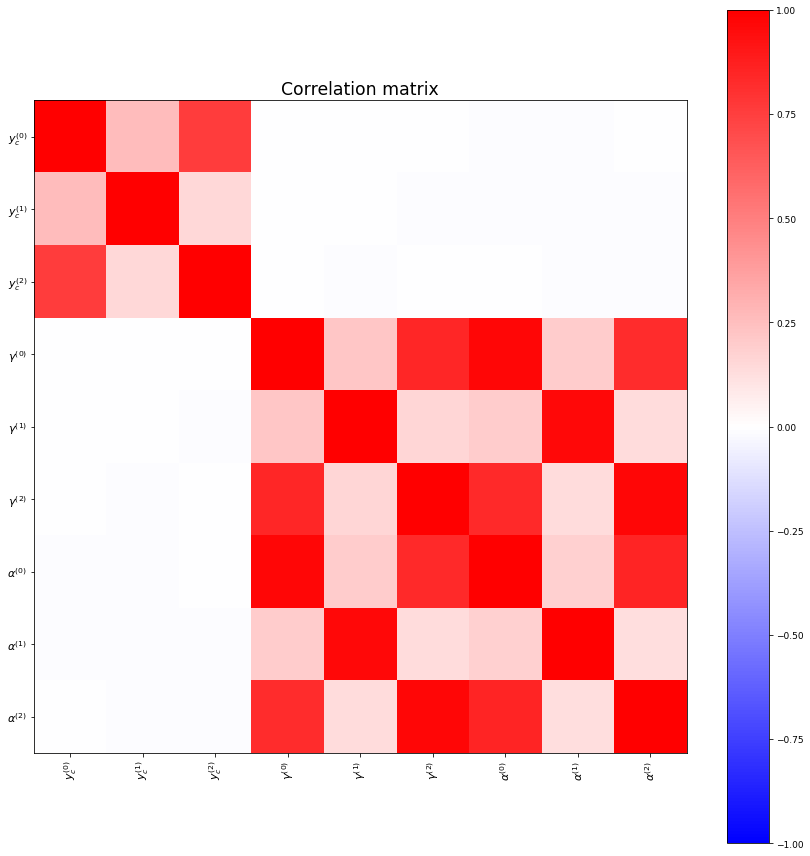

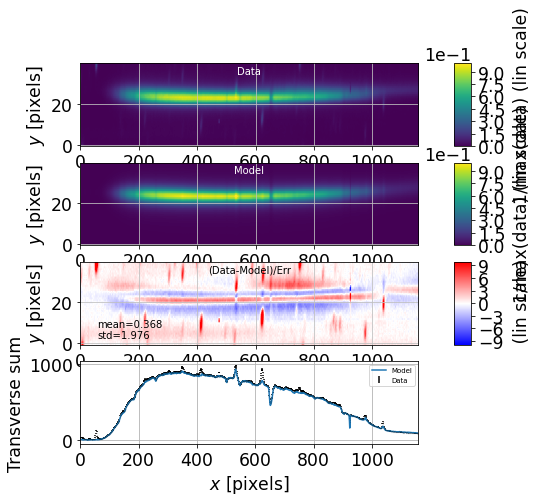

2021-09-29 13:54:57  spectractor.extractor.extractor extract_spectrum_from_image DEBUG  
	Transverse fit table before derotation:
    amplitude       x_c          y_c        ...         Dy         Dy_disp_axis
------------------ ------ ----------------- ... ------------------ ------------
 7.982795763165186    0.0 95.50089683543511 ...  5.498024617835526          0.0
 5.167505766954782    1.0  95.4906054108315 ...  5.487733193231918          0.0
 7.404312572788994    2.0 95.48033466631516 ... 5.4774624487155705          0.0
 8.666915867430168    3.0  95.4700846018861 ...  5.467212384286512          0.0
 6.865047182154696    4.0 95.45985521754433 ...  5.456982999944742          0.0
5.1313873013844375    5.0 95.44964651328982 ...  5.446774295690233          0.0
 4.563636172648922    6.0  95.4394584891226 ...  5.436586271523012          0.0
 5.169799331732605    7.0 95.42929114504267 ... 5.4264189274430805          0.0
2.9224048043574675    8.0    95.41914448105 ...  5.416272263450409    

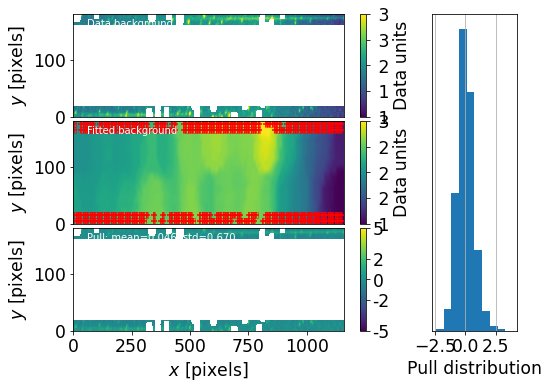

2021-09-29 13:55:00  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Background statistics: mean=2.100 ADU/s, RMS=0.282 ADU/s.
2021-09-29 13:55:00  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop image [584:1742,700:881] (size (1158, 181))
	New target position in spectrogram frame: [-425.2947058108779, 90.31691630808928]


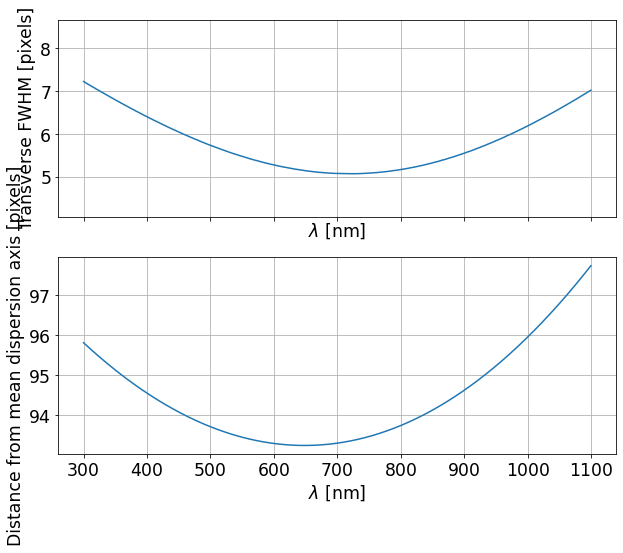

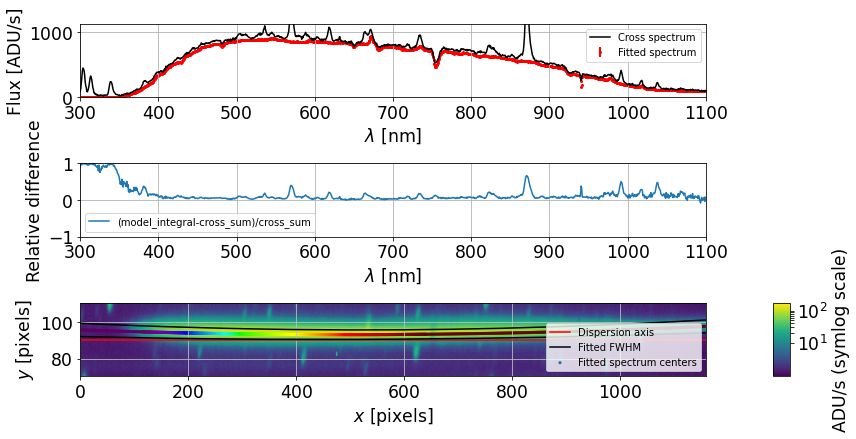

2021-09-29 13:55:03  spectractor.extractor.extractor Spectractor          INFO   
	Calibrating order 1 spectrum...


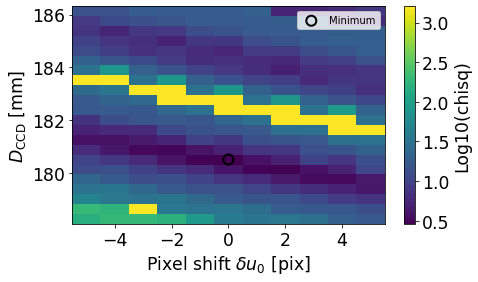

2021-09-29 13:55:19  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: 0.164pix
	D = 180.390 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -2.1 sigma shift)
2021-09-29 13:55:21  FullForwardModelFitWorkspace __init__             INFO   
	Full forward model fitting with regularisation parameter r=1.
2021-09-29 13:55:37  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=7.7407e+06 initial chisq_red=179.74
		 Line search: alpha_min=1.62 iter=1 funcalls=5
	Parameter shifts: [ 4.55372547 -0.01699303]
	New parameters: [ 4.55372547 -0.01699303]
	Final cost=1.1629e+06 final chisq_red=27.004 computed in 13.25s
2021-09-29 13:55:50  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=1.1629e+06 initial chisq_red=27.004
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-1.25028623  0.07639215]
	New parameters: [3.30343924 0.05939912]
	Final cost=1.1096e+06 final chisq_red=25.764 computed in 13.05s
2021-09-29 13:56:

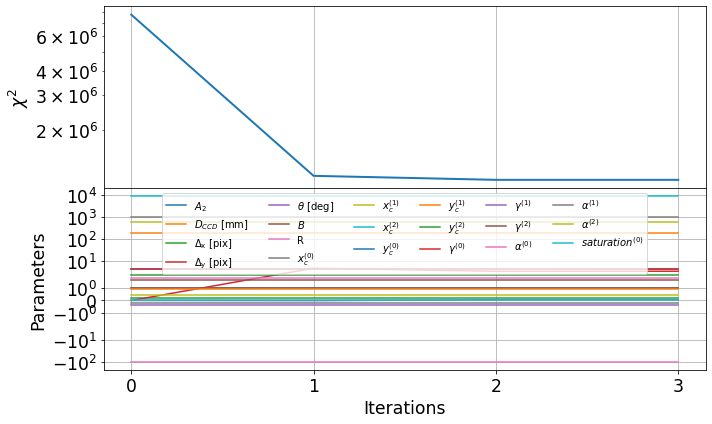

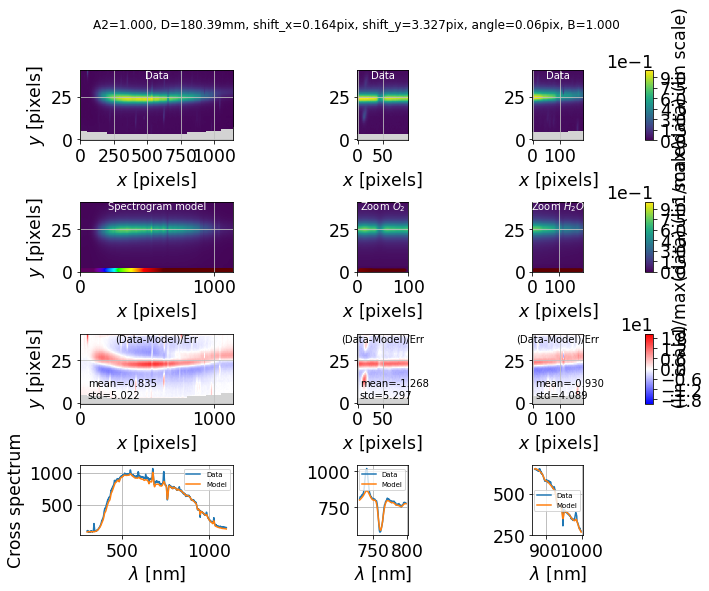

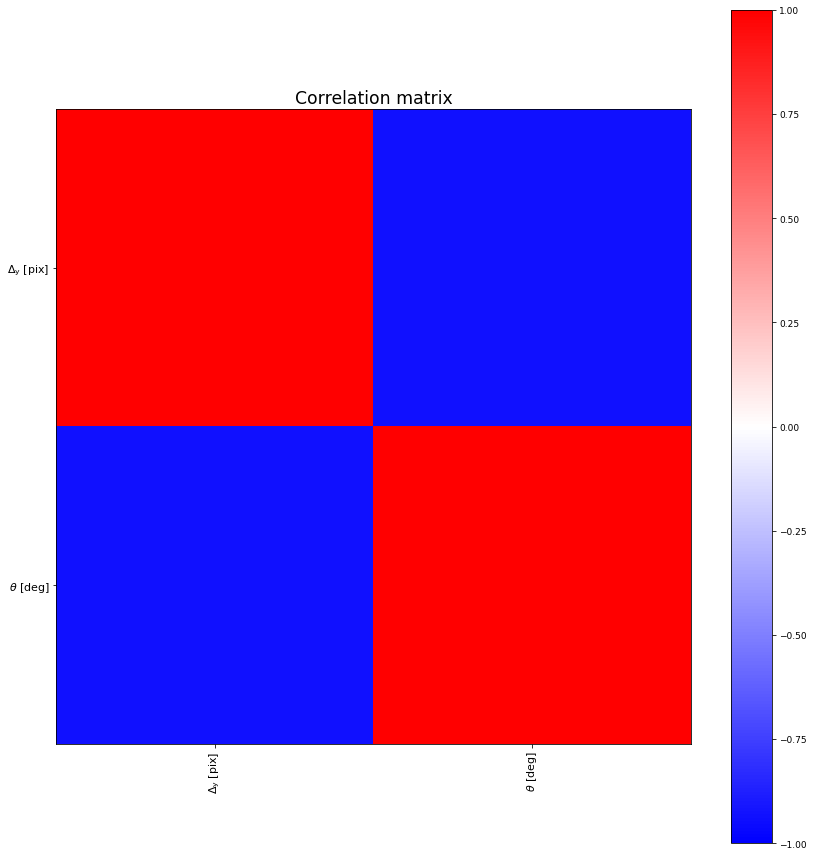

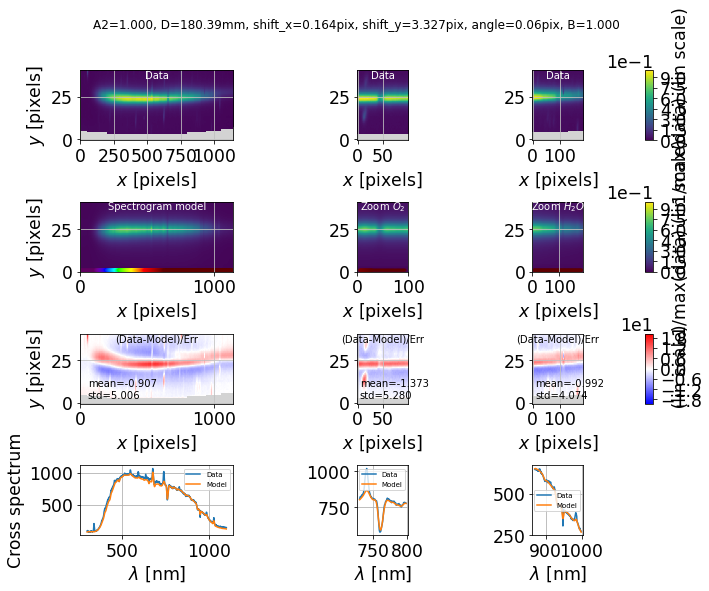

2021-09-29 13:56:13  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Start guess: [ 1.00000000e+00  1.80389664e+02  1.64207838e-01  3.32719144e+00
  5.82248246e-02  1.00000000e+00 -9.33059432e+01  1.00480539e+03
  5.78500000e+02 -6.98404888e-13  4.15235013e+00  9.61273691e-01
  2.30694818e+00  4.31262566e+00 -3.71127114e-01  1.63700681e+00
  1.84442831e+00 -1.87770186e-01  4.19289276e-01  8.50000000e+03]
	with ['A2', 'D_CCD [mm]', 'shift_x [pix]', 'shift_y [pix]', 'angle [deg]', 'B', 'R', 'x_c_0', 'x_c_1', 'x_c_2', 'y_c_0', 'y_c_1', 'y_c_2', 'gamma_0', 'gamma_1', 'gamma_2', 'alpha_0', 'alpha_1', 'alpha_2', 'saturation_0']
2021-09-29 13:56:38  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=1.1081e+06 initial chisq_red=25.731
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ 5.29555157e-04 -2.60706851e-03 -1.11647725e+00  1.65956310e-01
 -1.16129866e+00  5.75643949e-03  5.00929349e-02 -4.35962233e-01]
	New parameters: [ 3.327

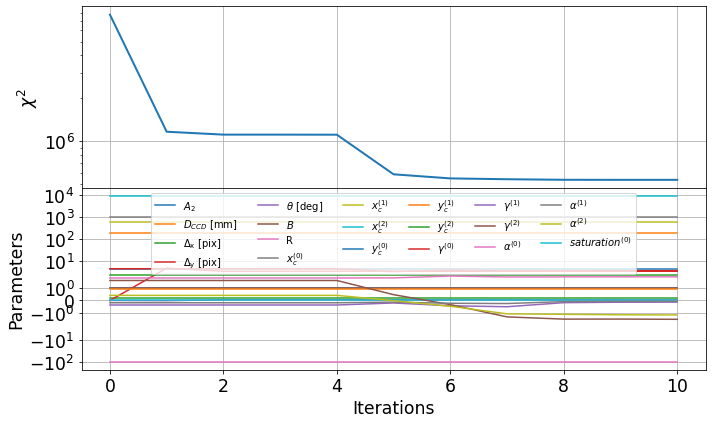

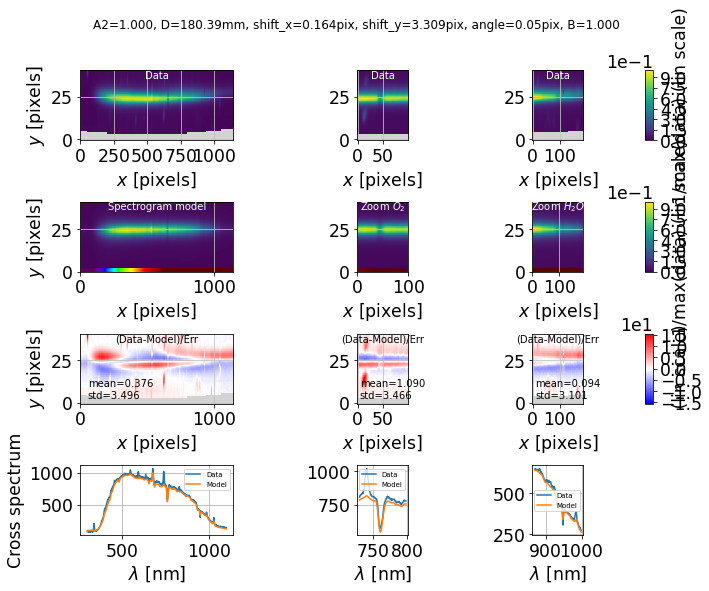

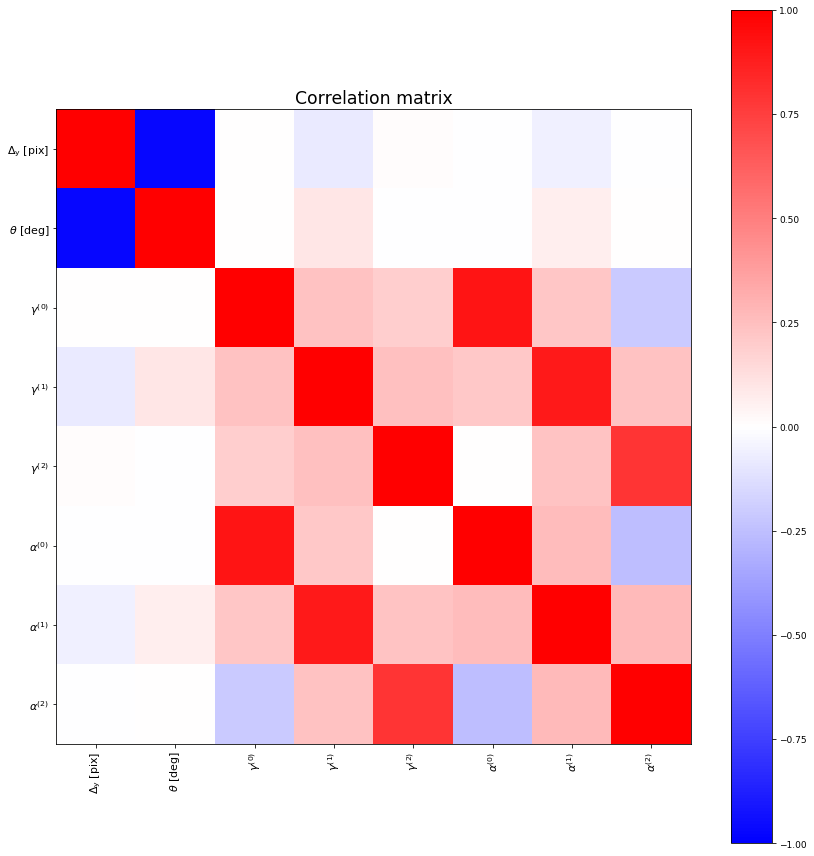

2021-09-29 14:02:50  spectractor.fit.fitter run_minimisation     DEBUG  
	Start guess: [0.]
/users/dagoret/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
2021-09-29 14:03:02  spectractor.fit.fitter run_minimisation     DEBUG  
	 final_simplex: (array([[2.570375 ],
       [2.5703125]]), array([4.19231626e-08, 4.19231626e-08]))
           fun: 4.192316263966772e-08
       message: 'Optimization terminated successfully.'
          nfev: 54
           nit: 27
        status: 0
       success: True
             x: array([2.570375])
2021-09-29 14:03:02  spectractor.fit.fitter run_minimisation     DEBUG  
	Minimize: total computation time: 11.98719596862793s


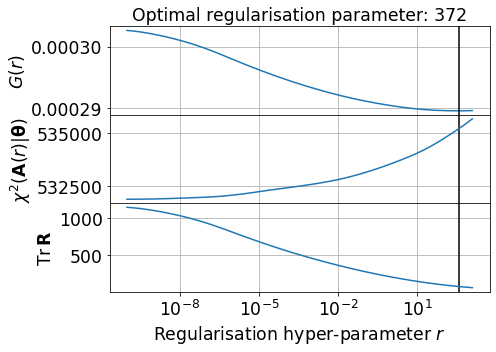

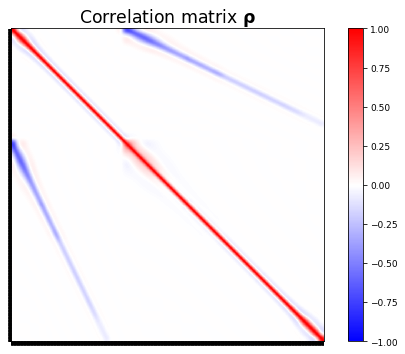

2021-09-29 14:03:30  RegFitWorkspace print_regularisation_summary INFO   
	Optimal regularisation parameter: 371.8561769465746
	Tr(R) = 73.44911687544382
	N_params = 1158
	N_data = 43066 (without mask and outliers)
2021-09-29 14:03:32  FullForwardModelFitWorkspace run_ffm_minimisation WARNING 
	Trace of final covariance matrix (4088.8414048939553) is below the trace of the prior covariance matrix (34455.972349767486). This is probably due to a very high regularisation parameter in case of a bad fit. Therefore the final covariance matrix is mulitiplied by the ratio of the traces and the amplitude parameters are very close the amplitude priors.
2021-09-29 14:03:54  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=5.3444e+05 initial chisq_red=12.426
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-0.01016822  0.00069566 -0.00288892  0.02260088 -0.00612693 -0.00504852
  0.01065616 -0.0132909 ]
	New parameters: [ 3.29894937  0.05376717  3.5118

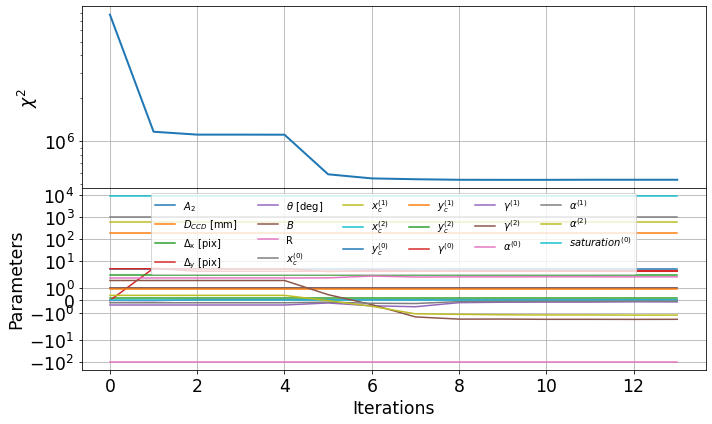

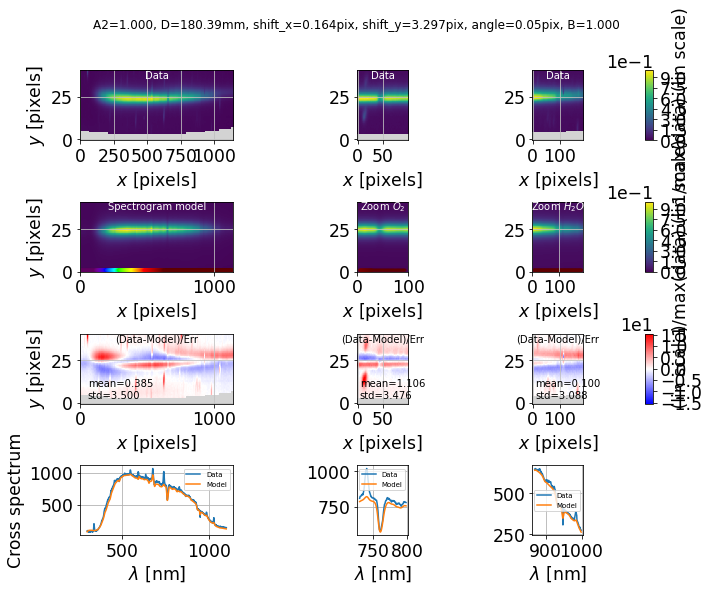

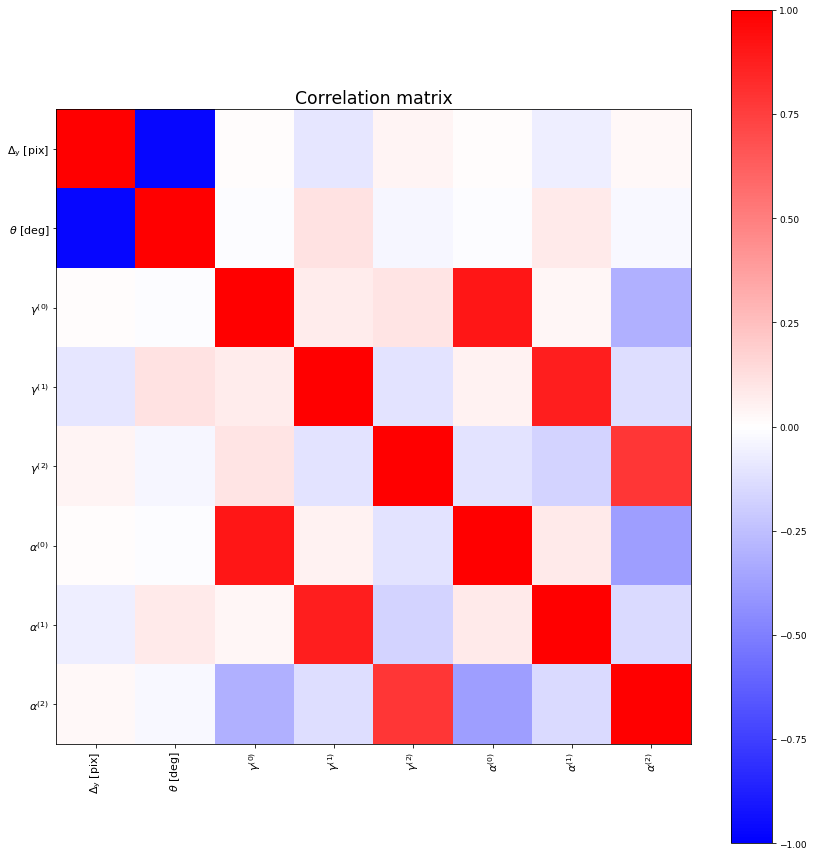

2021-09-29 14:04:19  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [14371, 15675, 32189, 44058, 44059, 45216, 45217, 45218, 46374, 46375, 46376, 46377]
2021-09-29 14:04:19  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 12 / 47478 data points (0.03%) at more than 20-sigma from best-fit model.
2021-09-29 14:04:40  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=5.2804e+05 initial chisq_red=12.277
		 Line search: alpha_min=0.382 iter=3 funcalls=7
	Parameter shifts: [ 1.38448804e-03 -8.18161006e-05 -9.04798288e-05  2.13887200e-03
 -3.00764117e-03  5.11573274e-05  8.80592023e-04 -1.41804171e-03]
	New parameters: [ 3.29830591  0.05378833  3.51378483 -0.11746087 -1.54647848  1.93454489
 -0.06116292 -1.19939314]
	Final cost=5.2804e+05 final chisq_red=12.277 computed in 19.70s
2021-09-29 14:05:06  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=5.2804e+05 initial

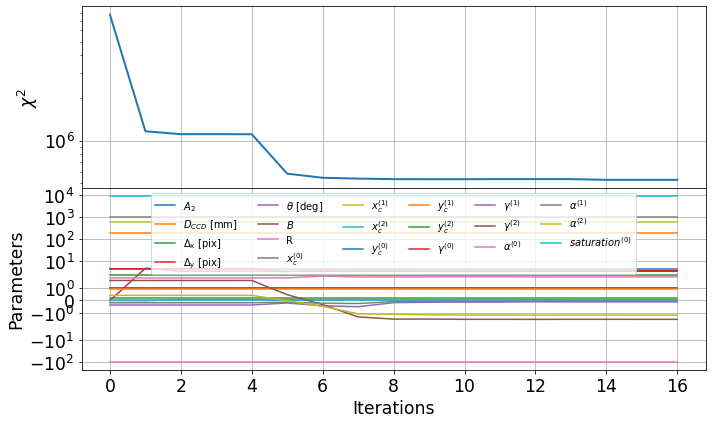

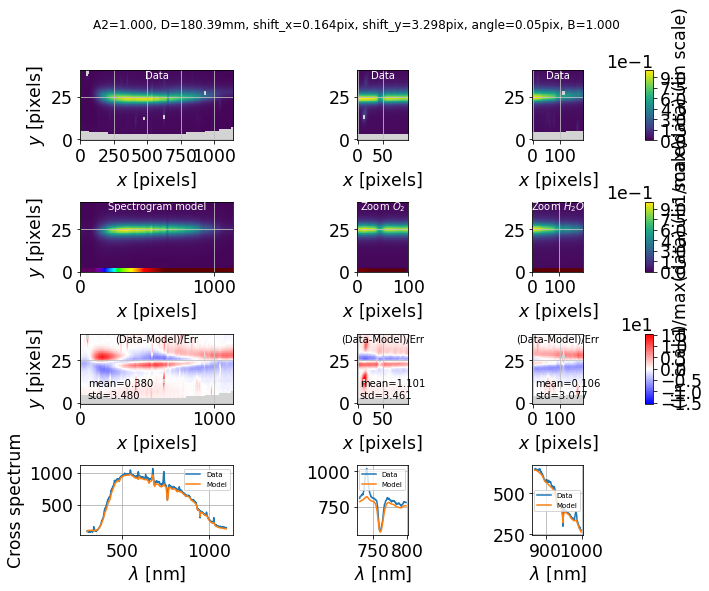

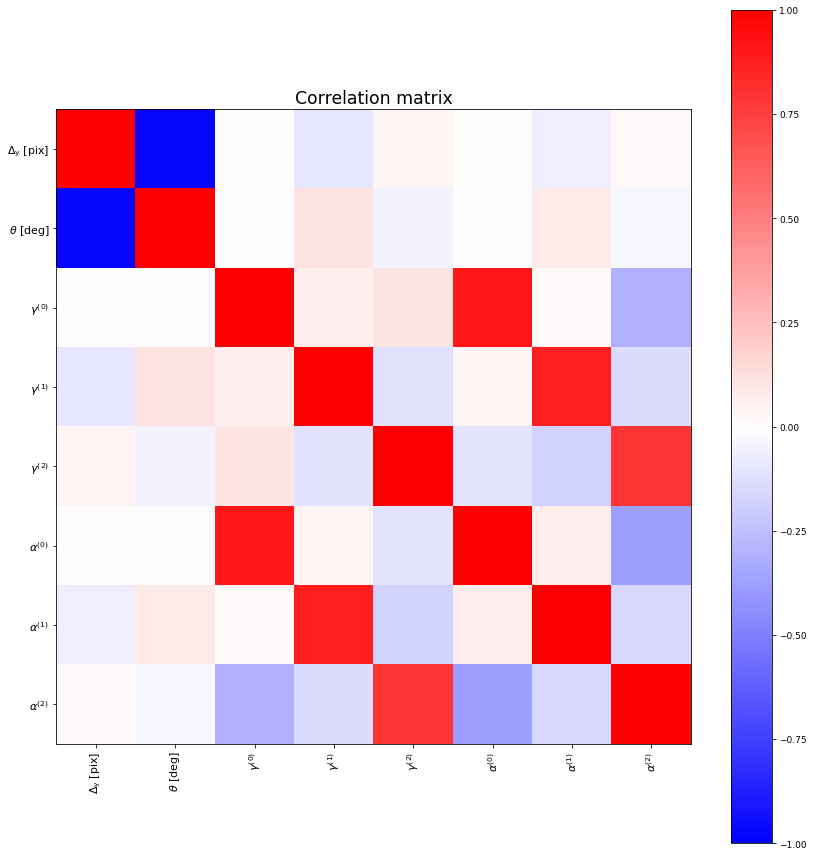

2021-09-29 14:05:10  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [14371, 15675, 32189, 44058, 44059, 45216, 45217, 45218, 46374, 46375, 46376, 46377]
2021-09-29 14:05:10  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 12 / 47478 data points (0.03%) at more than 20-sigma from best-fit model.
2021-09-29 14:05:10  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers flat index list unchanged since last iteration: break the sigma clipping iterations.
2021-09-29 14:05:10  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Newton: total computation time: 537.0656471252441s


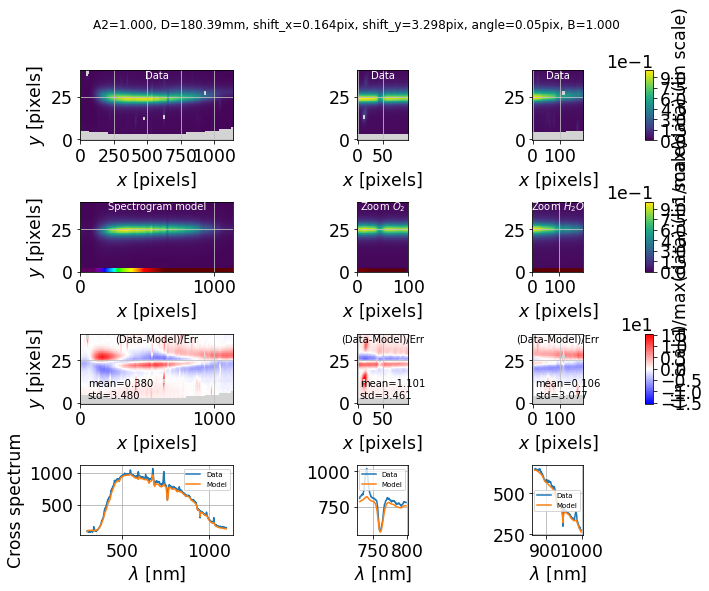

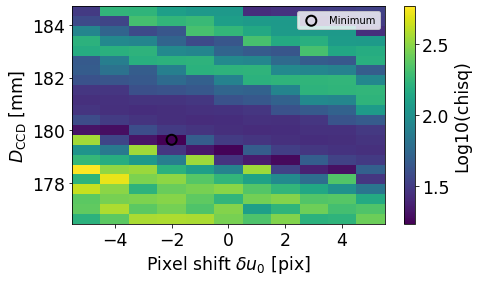

2021-09-29 14:05:37  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -1.998pix
	D = 179.640 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -3.1 sigma shift)
2021-09-29 14:06:00  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=5.2722e+05 initial chisq_red=12.258
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-7.92506860e-03 -8.33663512e-05  5.28887534e-03 -1.29206194e-02
  1.50804879e-03  3.78730079e-03 -5.02906277e-03  9.29059811e-03]
	New parameters: [ 3.29026827  0.05371191  3.51915858 -0.1306157  -1.54455356  1.93836217
 -0.06630425 -1.18991803]
	Final cost=5.2712e+05 final chisq_red=12.256 computed in 19.08s
2021-09-29 14:06:20  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=5.2712e+05 initial chisq_red=12.256
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-3.06083970e-04 -2.41773856e-06 -3.89578423e-04  1.56514183e-03
  2.24401803e-02 -4.23201186e-04 -1.57329023e-04  

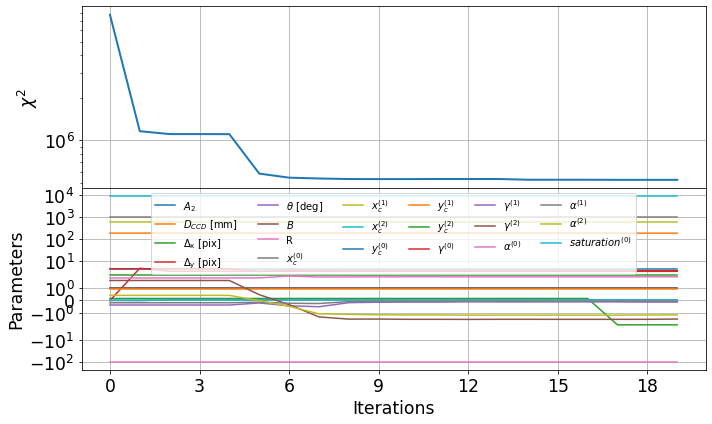

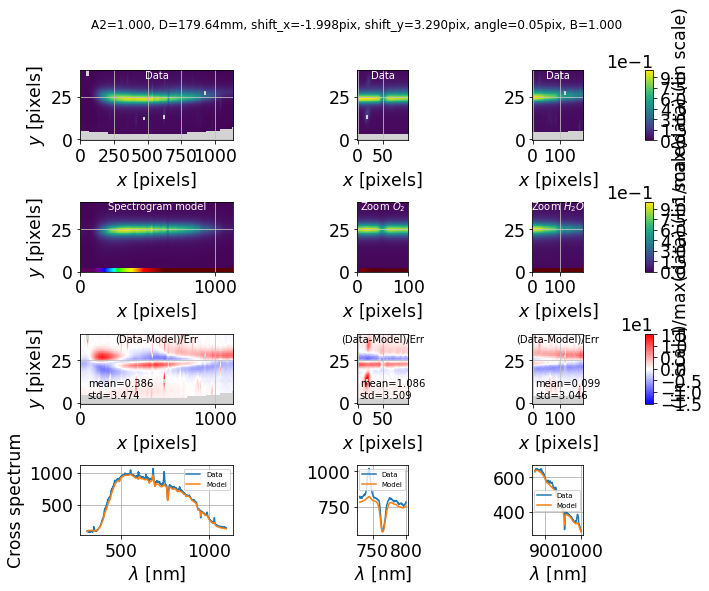

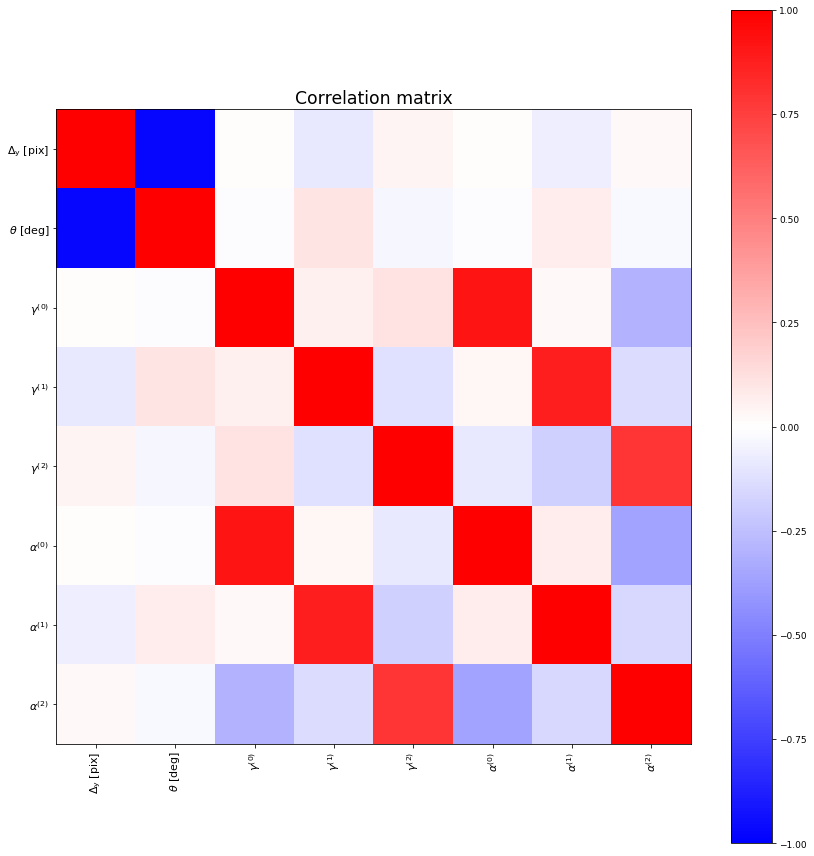

2021-09-29 14:06:25  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [14371, 15675, 32189, 44058, 44059, 45216, 45217, 45218, 46374, 46375, 46376, 46377]
2021-09-29 14:06:25  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 12 / 47478 data points (0.03%) at more than 20-sigma from best-fit model.
2021-09-29 14:06:25  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers flat index list unchanged since last iteration: break the sigma clipping iterations.
2021-09-29 14:06:25  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Newton: total computation time: 612.1557650566101s


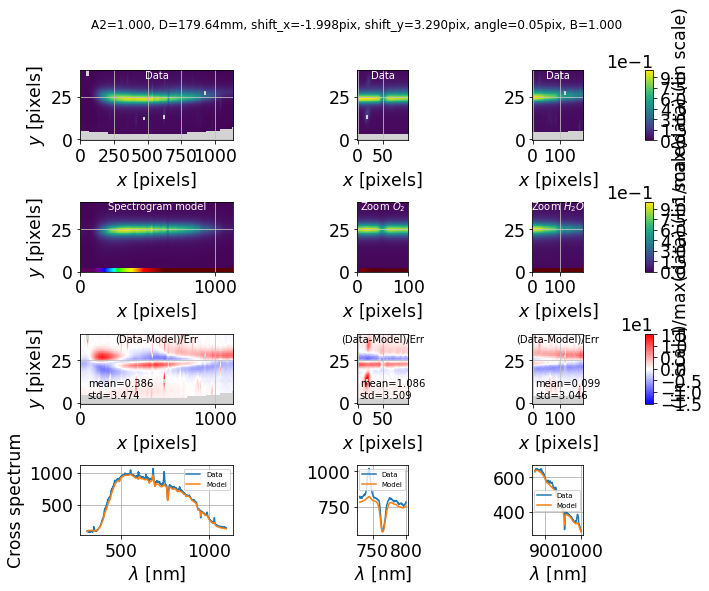

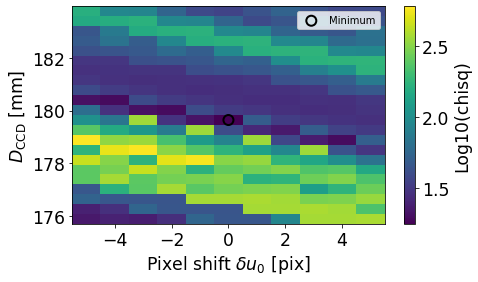

2021-09-29 14:06:49  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: 0.000pix
	D = 179.675 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -3.1 sigma shift)
2021-09-29 14:06:50  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.
2021-09-29 14:06:50  astroquery _showwarning         WARNING VerifyWarning: Card is too long, comment will be truncated.
2021-09-29 14:06:51  Spectrum   save_spectrum        INFO   
	Spectrum saved in ./outputs_process_holo_scan/holo4_003_empty_HD160617_20210707_000337_quickLookExp_spectrum.fits
2021-09-29 14:06:51  Spectrum   save_spectrogram     INFO   
	Spectrogram saved in ./outputs_process_holo_scan/holo4_003_empty_HD160617_20210707_000337_quickLookExp_spectrogram.fits


   Line   Tabulated  Detected   Shift    ...   Chisq   Eqwidth_mod Eqwidth_data
              nm        nm        nm     ...  reduced       nm          nm     
--------- --------- --------- ---------- ... --------- ----------- ------------
$H\delta$  410.3374  412.4269  2.0894852 ... 20.594202   0.2456165   0.07880575
 $Fe_{I}$ 430.93433 432.54065  1.6063195 ... 20.594202  0.39517984    1.2544823
$H\gamma$  434.1454  434.0621 -0.0832898 ... 20.594202  0.26048094    1.0280204
 $Fe_{I}$ 438.50186  436.3236 -2.1782296 ... 20.594202   0.1800862    0.9742319
 $He_{I}$  447.2498 449.95438  2.7045865 ... 20.594202  0.19765535    0.8810783
 $H\beta$ 486.46292  488.3728   1.909904 ... 3.7582393  0.35250932   0.35173988
 $Fe_{I}$  527.2156 527.72437  0.5088077 ... 3.7582393 0.091147624  0.034483373
$H\alpha$ 656.51984  659.2921   2.772249 ... 3.1511242   0.3250277    0.3452502
              760.3 756.71075  -3.589218 ... 40.393787  0.34426495    3.5968082
    $O_2$     763.1 765.37067   2.270687

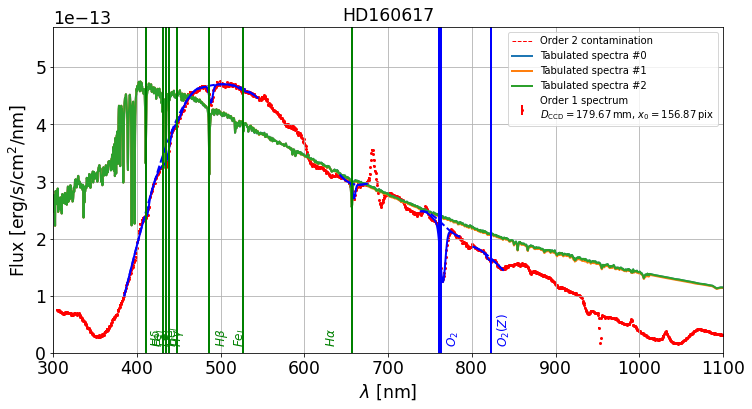

In [116]:
#spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)
spectrum = Spectractor(filename_image, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)

# Remove temporary input image file (current directory)

In [117]:
os.remove(filename_image)

# Backup output

In [118]:
copy_tree(output_directory,os.path.join(finalpath_output_spectractor,"basespec"))

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000337_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000337_quickLookExp_lines.csv',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000337_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000337_quickLookExp_table.csv',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000337_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000337_quickLookExp_spectrogram.fits',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000337_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000337_quickLookExp_spectrum.fits']

In [119]:
copy_tree(output_figures,os.path.join(finalpath_output_spectractor,"plots"))

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000337_quickLookExp/plots/fit_chromatic_psf_best_fit_noprior.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000337_quickLookExp/plots/rotated_image.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000337_quickLookExp/plots/fwhm.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000337_quickLookExp/plots/order0_centroid_fit.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000337_quickLookExp/plots/HD160617_spectrum.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000337_quickLookExp/plots/regularisation.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/